# Calibration Matrix in KITTI dataset

[[7.43613733e+02 0.00000000e+00 6.28209262e+02 4.62297250e+01]
 [0.00000000e+00 7.38854605e+02 1.77002496e+02 2.21572198e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 2.74588400e-03]]
[[ 7.39397961e+02  0.00000000e+00  6.31719111e+02  4.78518275e+01]
 [ 0.00000000e+00  7.33802517e+02  1.87336579e+02 -3.58485483e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  4.98101600e-03]]
[[ 7.42705111e+02  0.00000000e+00  6.20757712e+02  4.60136426e+01]
 [ 0.00000000e+00  7.37541921e+02  1.86365467e+02 -6.11022751e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.61631500e-03]]
[[ 7.41446962e+02  0.00000000e+00  6.26274604e+02  4.68084448e+01]
 [ 0.00000000e+00  7.34150809e+02  1.89156460e+02 -1.15494843e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  3.77976100e-03]]


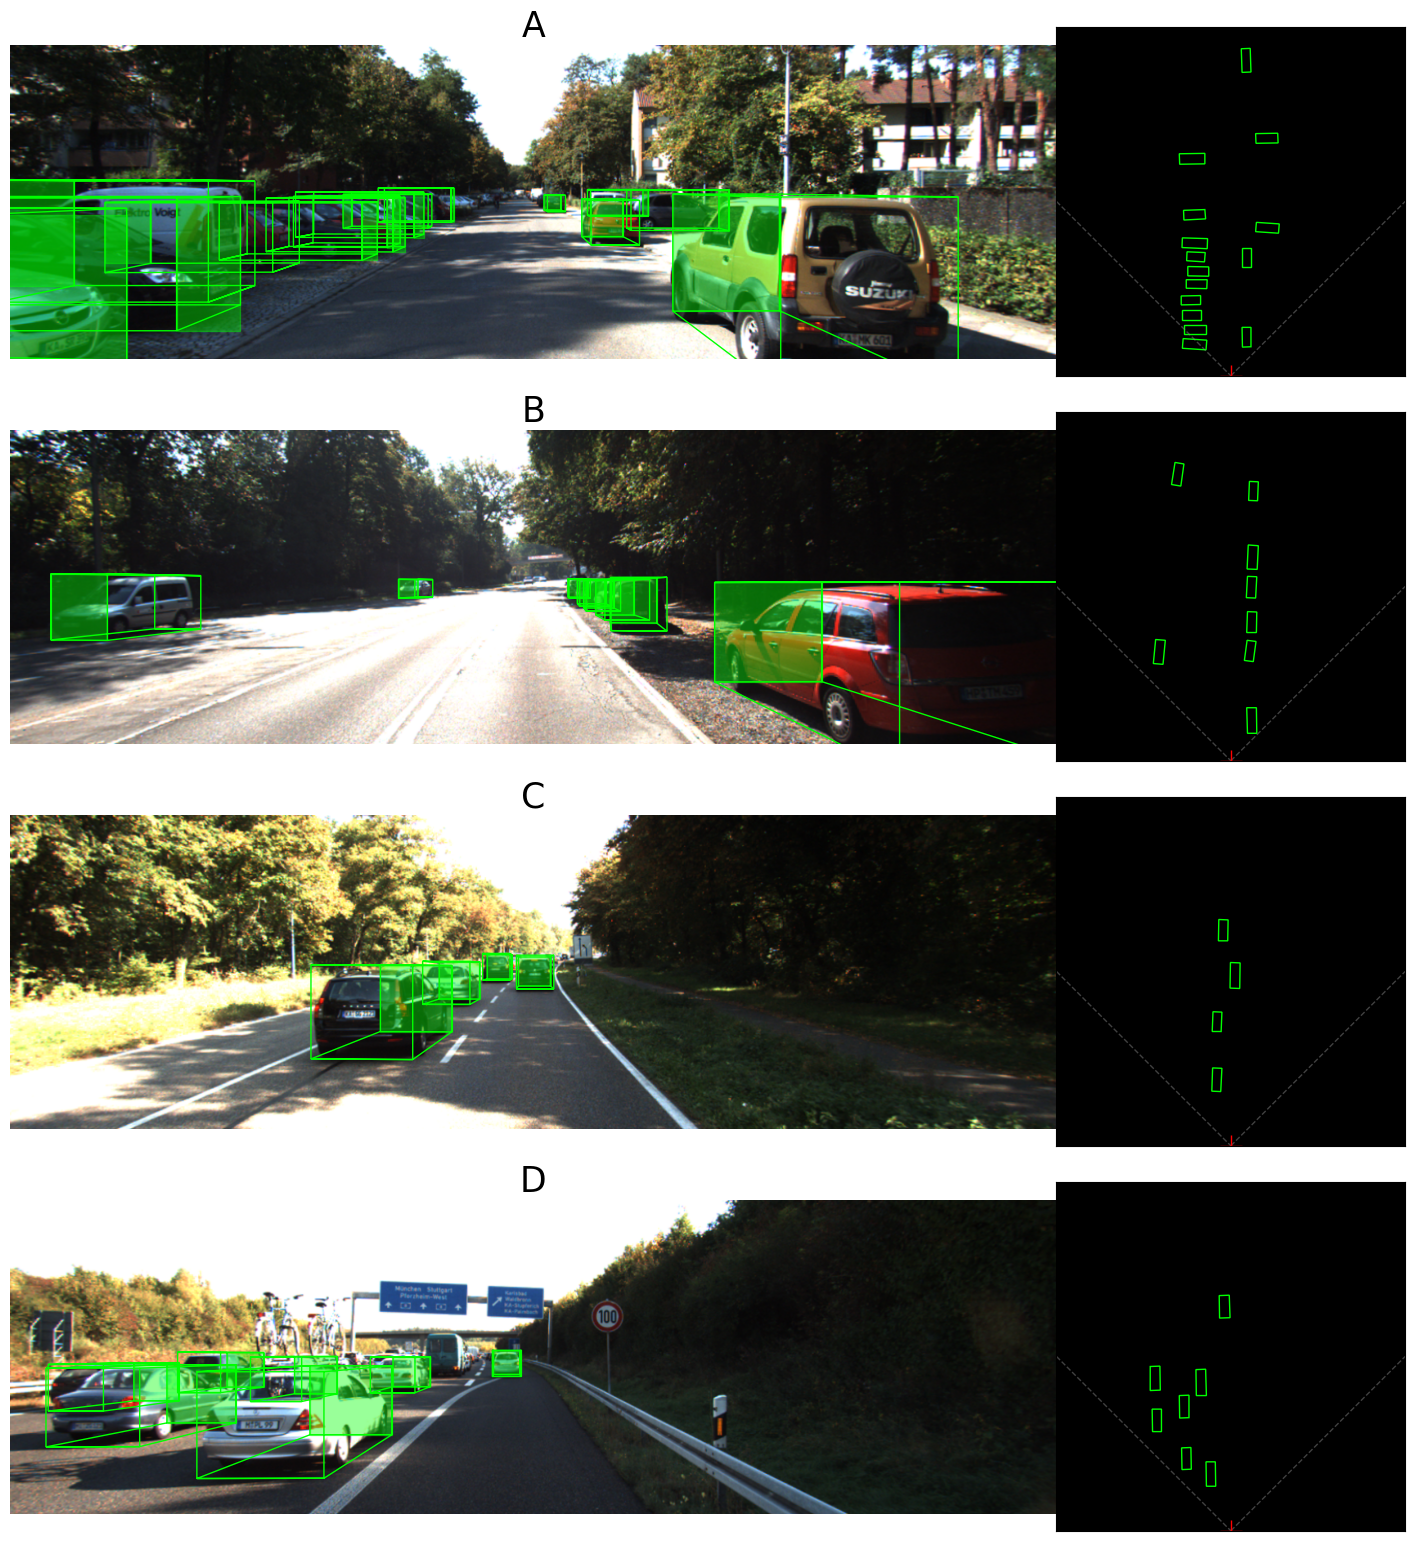

In [24]:
# KITTI provides camera calibration matrix for every image,
# There are only four type of calibration matrix listed here as type A, B, C, D  
import os
import matplotlib.pyplot as plt
import statistics 
import numpy as np
import cv2
from math import sqrt 
from collections import defaultdict
import sys
import glob
visualDet3D_path = os.path.dirname(sys.path[0])  #two folders upwards
sys.path.insert(0, visualDet3D_path)

from visualDet3D.utils.util_kitti import load_tf_image, init_img_plt_without_bev, init_img_plt, draw_birdeyes, draw_corner_2D, kitti_calib_file_parser, kitti_label_file_parser

IMAGE_DIR = "../dataset/kitti/training/image_2/"
LABEL_DIR = "../dataset/kitti/training/label_2/"
CALIB_DIR = "../dataset/kitti/training/calib/"

img_dict = {'A': '000169', 'B': '000338', 'C': '000259', 'D': '003563'}
mappppp = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}

imgs = []
P2s = []
for type in img_dict:
    img = cv2.imread( os.path.join(IMAGE_DIR, f"{img_dict[type]}.png") )
    P2 = kitti_calib_file_parser(os.path.join(CALIB_DIR, f"{img_dict[type]}.txt") )
    
    img_ori_h, img_ori_w, _ = img.shape
    # Resize
    P2[0, :] *= 1280  / img_ori_w
    P2[1, :] *= 384   / img_ori_h
    print(P2)
    img = cv2.resize(img, (1280, 384))
    
    imgs.append(img)
    P2s.append(P2)

axs = init_img_plt(imgs, titles = ['A', 'B', 'C', 'D'])

for i in range(4):
    objs = kitti_label_file_parser(os.path.join(LABEL_DIR, f"{img_dict[mappppp[i] ]}.txt"), tf_matrix = P2s[i])

    # Draw annotation on image
    for obj in objs:
        if obj.category == "Car":
            draw_birdeyes(axs[i][1], obj, color = (0,1,0), title = "123", is_print_confident = False)
            draw_corner_2D(axs[i][0], obj.corner_2D, color = (0,1,0), is_draw_front = True, )

# Statistic of KITTI dataset

Number of total ground trues = 51865
Categories: 
Car: 28742
Van: 2914
DontCare: 11295
Cyclist: 1627
Pedestrian: 4487
Truck: 1094
Person_sitting: 222
Tram: 511
Misc: 973
Truncated Objects:
Number of truncated object = 4067, 7.84%
Occluded objects:
0: 13457  (46.82%)
1: 8184  (28.47%)
2: 6173  (21.48%)
3: 928  (3.23%)
Dimension: 
Average height = 1.526
Average width  = 1.629
Average length = 3.884
Std height = 0.137
Std width  = 0.102
Std length = 0.426
Average height = 1.71
Mean of y_3d = 1.7097738501148145
Mean of z_3d = 28.01284044255793
Std of y_3d = 0.3857424915081378
Std of z_3d = 16.32088065975966


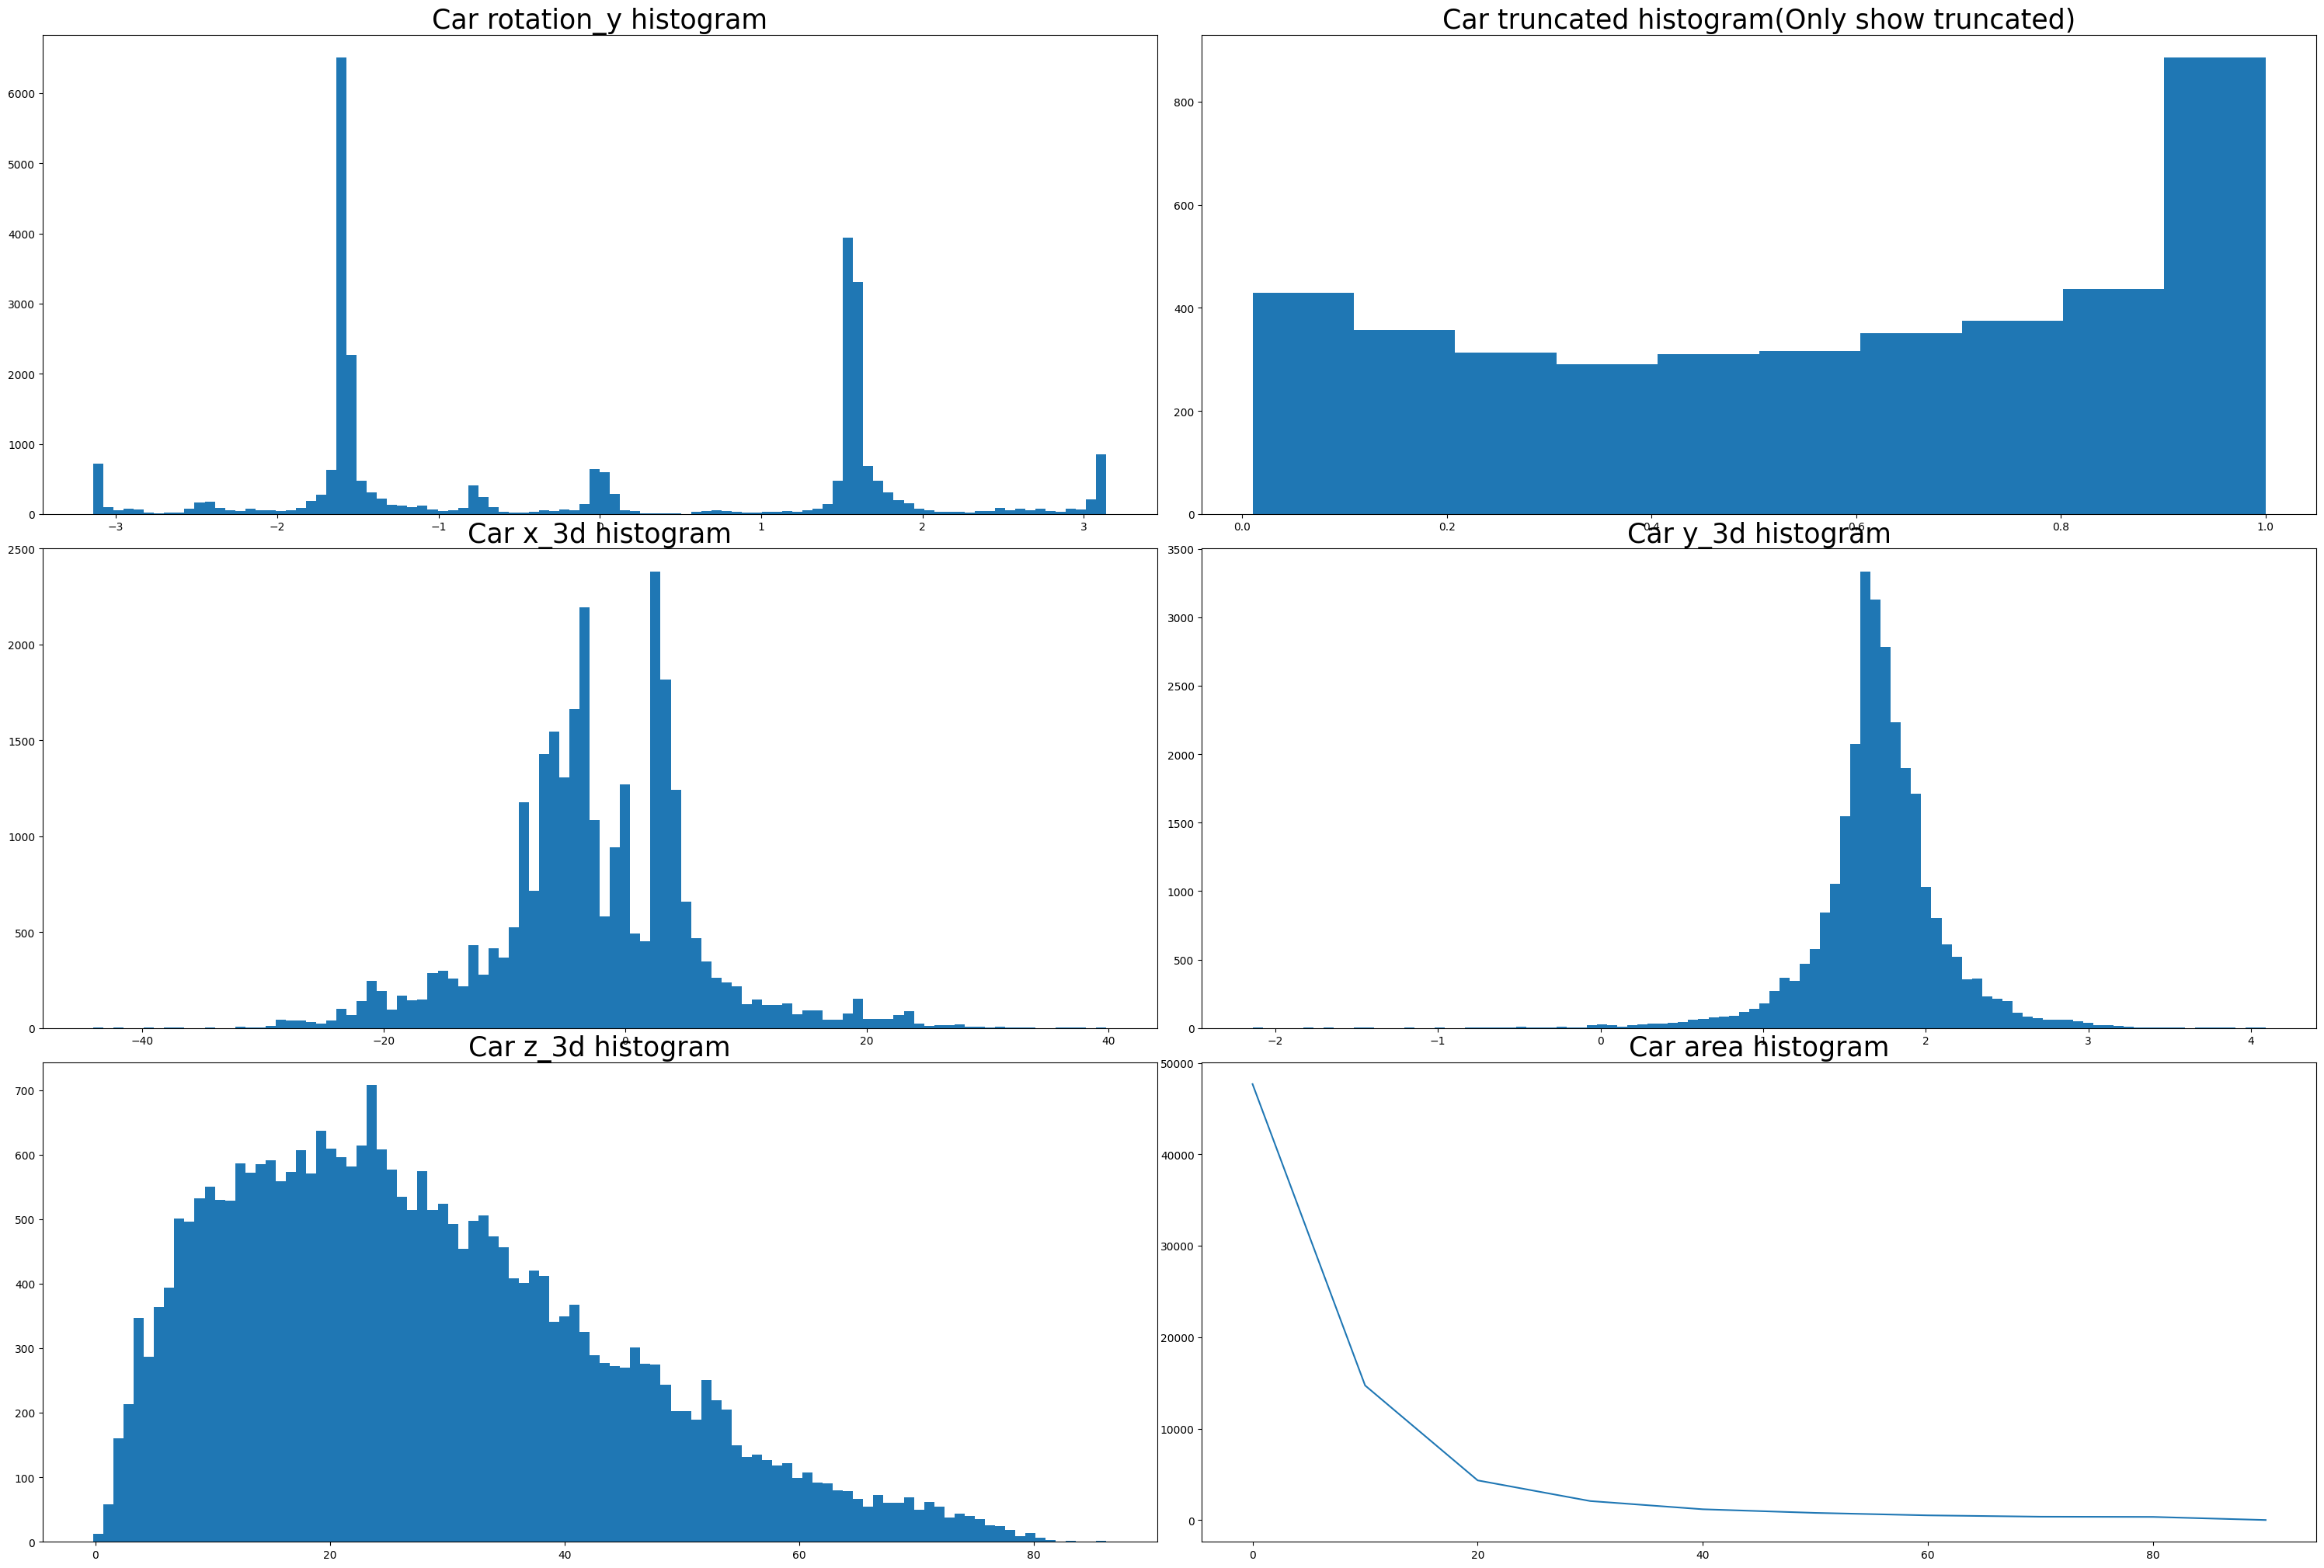

In [25]:
objs = []
for fn in glob.glob(LABEL_DIR + "*.txt"):
    tf_matrix = kitti_calib_file_parser( os.path.join(CALIB_DIR, fn.split("/")[-1]) )
    objs += kitti_label_file_parser(fn, tf_matrix)
print(f"Number of total ground trues = {len(objs)}")
print("=====================================")
kitti_calib_file_parser
# Show category
print("Categories: ")
cls_dict = defaultdict(int)
for obj in objs:
    cls_dict[obj.category] += 1

for cls in cls_dict:
    print(f"{cls}: {cls_dict[cls]}")
print("=====================================")

# Show truncated objects
print("Truncated Objects:")
N_BIN_TRUNCATED = 10
x_truncated = []
not_truncated_count = 0 
for obj in objs:
    if obj.category == "Car":
        if obj.truncated == 0.0: # Not truncated
            not_truncated_count += 1
        else:
            x_truncated.append(obj.truncated)
print(f"Number of truncated object = {len(x_truncated)}, {round(100*len(x_truncated)/len(objs), 2)}%")

print("=====================================")
print("Occluded objects:")
occ_dict = defaultdict(int)
for obj in objs:
    if obj.category == "Car":
        occ_dict[obj.occluded] += 1
for i in occ_dict:
    print(f"{i}: {occ_dict[i]}  ({round(100*occ_dict[i]/cls_dict['Car'],2)}%)")
print("=====================================")
print("Dimension: ")
avg_h, avg_w, avg_l  = 0, 0, 0

for obj in objs:
    if obj.category == "Car":
        avg_h += obj.h / cls_dict['Car']
        avg_w += obj.w / cls_dict['Car']
        avg_l += obj.l / cls_dict['Car']
print(f"Average height = {round(avg_h, 3)}")
print(f"Average width  = {round(avg_w, 3)}")
print(f"Average length = {round(avg_l, 3)}")

# Calculate STD
print("=====================================")
std_h, std_w, std_l = 0, 0, 0
for obj in objs:
    if obj.category == "Car":
        std_h += (obj.h - avg_h)**2 / cls_dict['Car']
        std_w += (obj.w - avg_w)**2 / cls_dict['Car']
        std_l += (obj.l - avg_l)**2 / cls_dict['Car']
std_h = sqrt(std_h)
std_w = sqrt(std_w)
std_l = sqrt(std_l)
print(f"Std height = {round(std_h, 3)}")
print(f"Std width  = {round(std_w, 3)}")
print(f"Std length = {round(std_l, 3)}")

# TODO, BTW, I think using validation data to do statistic is slight cheating
print("=====================================")
avg_y_3d = 0
for obj in objs:
    if obj.category == "Car":
        avg_y_3d += obj.y3d / cls_dict['Car']
print(f"Average height = {round(avg_y_3d, 3)}")

# Show rotation_y histogram
N_BIN_ROTATION_Y = 100
x_rotation_y = []
for obj in objs:
    if obj.category == "Car":
        x_rotation_y.append(obj.rot_y)

# Show x_3d 
N_BIN_X_3D = 100
x_x_3d = []
for obj in objs:
    if obj.category == "Car":
        x_x_3d.append(obj.x3d)

# Show y_3d 
N_BIN_Y_3D = 100
x_y_3d = []
for obj in objs:
    if obj.category == "Car":
        x_y_3d.append(obj.y3d)

# Show z_3d 
N_BIN_Z_3D = 100
x_z_3d = []
for obj in objs:
    if obj.category == "Car":
        x_z_3d.append(obj.z3d)

# Show area 
# N_BIN_AREA_3D = 100
area_z_bin = [[] for _ in range(10)]
for obj in objs:
    if obj.category == "Car":
        area_z_bin[ int(obj.z3d/10) ].append(obj.area)
new_bin = []
for i in area_z_bin:
    try: 
        new_bin.append(sum(i) / len(i))
    except ZeroDivisionError:
        new_bin.append(0)


# Draw histogram
fig, ax = plt.subplots(3, 2, figsize=(30, 20))
fig.set_facecolor('white')
fig.tight_layout()

ax[0, 0].set_title("Car rotation_y histogram", fontsize=25)
ax[0, 0].hist(x_rotation_y, bins=N_BIN_ROTATION_Y)
ax[0, 1].set_title("Car truncated histogram(Only show truncated)", fontsize=25)
ax[0, 1].hist(x_truncated, bins=N_BIN_TRUNCATED)
ax[1, 0].set_title("Car x_3d histogram", fontsize=25)
ax[1, 0].hist(x_x_3d, bins=N_BIN_X_3D)
ax[1, 1].set_title("Car y_3d histogram", fontsize=25)
ax[1, 1].hist(x_y_3d, bins=N_BIN_Y_3D)
ax[2, 0].set_title("Car z_3d histogram", fontsize=25)
ax[2, 0].hist(x_z_3d, bins=N_BIN_Z_3D)
ax[2, 1].set_title("Car area histogram", fontsize=25)
ax[2, 1].plot(list(range(0, 100 ,10)), new_bin)

print(f"Mean of y_3d = {statistics.mean(x_y_3d)}")
print(f"Mean of z_3d = {statistics.mean(x_z_3d)}")

print(f"Std of y_3d = {statistics.stdev(x_y_3d)}")
print(f"Std of z_3d = {statistics.stdev(x_z_3d)}")



# Check relationship between u, y, z

In [26]:
'''
I want to know whether P2 precise -> It's actually very precise with only 0.4mm error
No wonder GAC deson't regress x3d, y3d becuase it's very precise to get it from (cx, cy)
cz is the only variable we need to seriously regress
'''
sum_diff = 0
sum_abs_diff = 0
n_gt = 0
for fn in glob.glob(LABEL_DIR + "*.txt"):
    P2 = kitti_calib_file_parser( os.path.join(CALIB_DIR, fn.split("/")[-1]) )
    objs = kitti_label_file_parser(fn, P2)
    for obj in objs:
        if obj.category == "Car":
            y3d = obj.cz * (obj.cy - P2[1, 2] ) / P2[1, 1] + obj.h/2
            sum_diff += y3d - obj.y3d
            sum_abs_diff += abs(y3d - obj.y3d)
            n_gt += 1
print(f"Avg diff = {sum_diff / n_gt}")
print(f"Avg abs diff = {sum_abs_diff / n_gt}")

Avg diff = -0.00047593679969887975
Avg abs diff = 0.00047593679969887975


# Check 2D bounding box vs 3D bounding box project to image plane

In [27]:
'''
I want to know whether 2D bbox <--> 3D bounding box projection has a big difference
But actually its has very little error in this experiement 
Note that I have to ignore all truncated objects in this experiment 
because truncated object is bounded to have big different 
'''

xc_diff_sum = 0
yc_diff_sum = 0
h_diff_sum = 0
w_diff_sum = 0
n_gt = 0
for fn in glob.glob(LABEL_DIR + "*.txt"):
    P2 = kitti_calib_file_parser( os.path.join(CALIB_DIR, fn.split("/")[-1]) )
    objs = kitti_label_file_parser(fn, P2)
    for obj in objs:
        if obj.category == "Car" and obj.truncated == 0.0: # Ignore truncated object
            xmin = obj.corner_2D[0].min()
            ymin = obj.corner_2D[1].min()
            xmax = obj.corner_2D[0].max()
            ymax = obj.corner_2D[1].max()
            xc_f3d , yc_f3d = ( (xmin + xmax) / 2, (ymin + ymax) / 2 )
            w_f3d  , h_f3d  = ( (xmax - xmin)    , (ymax - ymin)     )
            xc_lab , yc_lab = ( (obj.xmin + obj.xmax) / 2, (obj.ymin + obj.ymax) / 2 )
            w_lab  , h_lab  = ( (obj.xmax - obj.xmin)    , (obj.ymax - obj.ymin)     )
            
            xc_diff_sum += abs(xc_lab - xc_f3d)
            yc_diff_sum += abs(yc_lab - yc_f3d)
            h_diff_sum  += abs(h_lab - h_f3d)
            w_diff_sum  += abs(w_lab - w_f3d)

            n_gt += 1

print(f"Avg xc abs diff = {xc_diff_sum / n_gt}")
print(f"Avg yc abs diff = {yc_diff_sum / n_gt}")
print(f"Avg h abs diff = {h_diff_sum / n_gt}")
print(f"Avg w abs diff = {w_diff_sum / n_gt}")
print(f"Number of Ground true  = {n_gt}")

Avg xc abs diff = 0.709109791757586
Avg yc abs diff = 0.7225194765791769
Avg h abs diff = 0.7397038768332103
Avg w abs diff = 0.5744506009682719
Number of Ground true  = 24675


Number of total ground trues = 28742


[<Axes: title={'center': 'All Groundtrues'}>]

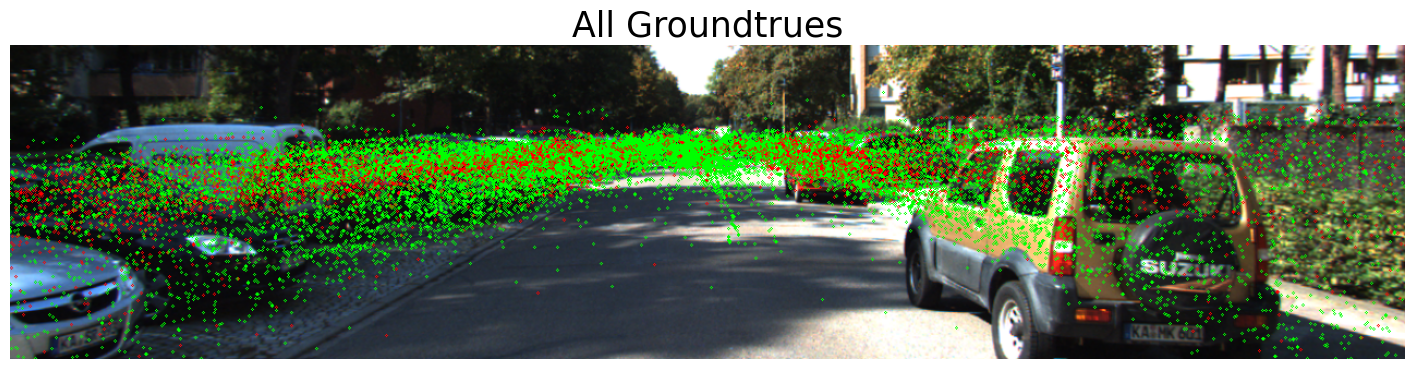

In [28]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import statistics
import numpy as np
import sys
import random
from scipy.optimize import curve_fit
import pickle
import glob
# sys.path.insert(0, "../kitti/")
# from util_kitti import kitti_calib_file_parser, kitti_label_file_parser, init_img_plt_without_bev, gac_original_anchor_parser, init_zy_plt, load_tf_image
import os
import cv2

img_tf = load_tf_image(os.path.join(IMAGE_DIR, "000169.png")) # "/home/lab530/KenYu/kitti/training/image_2/000169.png")

labels = []
for fn in glob.glob(LABEL_DIR + "*.txt"):
    # kitti_calib_file_parser(calib_file_path, new_shape_tf = None, crop_tf = 0)
    P2 = kitti_calib_file_parser( fn.replace("label_2", "calib"), new_shape_tf = (288, 1280), crop_tf = 100)

    for label in kitti_label_file_parser(fn, P2):
        # filter labal via gac_original's critiria
        # if label.occluded >= 2 or label.z3d <= 3 or label.category != "Car":
        #     continue
        # else:
        if label.category == "Car":
            labels.append(label)

print(f"Number of total ground trues = {len(labels)}")
print("=====================================")


for label in labels:
    x1 = label.corner_2D[0].min()
    y1 = label.corner_2D[1].min()
    x2 = label.corner_2D[0].max()
    y2 = label.corner_2D[1].max()

    x_center = int( (x2 + x1)/2 )
    y_center = int( (y2 + y1)/2 )
    
    if label.occluded >= 2 or label.z3d <= 3:
        cv2.circle(img_tf, (x_center, y_center), 1, (0,0,255), 1)
        
    else:# Filtered object
        cv2.circle(img_tf, (x_center, y_center), 1, (0,255,0), 1)
        

init_img_plt_without_bev([img_tf], ["All Groundtrues", ""])
